In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../../../../Datasets/MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../../../Datasets/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../../../Datasets/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../../../../Datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../../../Datasets/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
# Hyper-Parameters
TRAINING_EPOCHS = 1000
LEARNING_RATE = 0.0001
CODE_VECTOR = 10
HIDDEN_LAYER_UNITS = [512, 384, 256]
ACTIVATION_FUNCTION = tf.nn.elu  # tf.nn.selu
num_of_features = mnist.train.images[0].shape[0]

In [4]:
class EncoderDecoderNetwork_VAE:
    def __init__(
            self,
            input_channels,
            output_channels,
            hidden_layer_sizes=[1000, 500, 250],
            n_dims_code=125,
            learning_rate=0.001,
            activation_fn=tf.nn.elu,
            training_epochs=1000,
    ):
        """
        Implement an encoder decoder network and train it

        :param input_channels: number of source robot features
        :param output_channels: number of target robot features
        :param hidden_layer_sizes: units in hidden layers
        :param n_dims_code: code vector length
        :param learning_rate: learning rate
        :param activation_fn: activation function
        """
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.hidden_layer_sizes = hidden_layer_sizes
        self.n_dims_code = n_dims_code
        self.learning_rate = learning_rate
        self.activation_fn = activation_fn
        self.training_epochs = training_epochs

        self.X = tf.placeholder("float", [None, self.input_channels], name='InputData')
        self.Y = tf.placeholder("float", [None, self.output_channels], name='OutputData')

        self.code_prediction, self.z_mu, self.z_log_sigma_sq = self.encoder()
        self.output = self.decoder(self.code_prediction)

        # Define loss
        with tf.name_scope('Loss'):
            # shaohua0116_demo
            # Not working: nans in loss
            epsilon = 1e-10
            recon_loss = -tf.reduce_sum(self.Y * tf.log(epsilon+self.output) + (1-self.Y) * tf.log(epsilon+1-self.output), axis=1)
            self.cost = tf.reduce_mean(recon_loss)

            # Latent loss
            # Kullback Leibler divergence: measure the difference between two distributions
            # Here we measure the divergence between the latent distribution and N(0, 1)
            self.latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq - tf.square(self.z_mu) - tf.exp(self.z_log_sigma_sq), axis=1)
            #print("latent_loss: ", self.latent_loss)
            self.latent_loss = tf.reduce_mean(self.latent_loss)
            #print("latent_loss: ", self.latent_loss)

            self.cost = tf.reduce_mean(self.cost + self.latent_loss)
            #print("cost: ", self.cost)

        # Define optimizer
        with tf.name_scope('Optimizer'):
            self.train_op = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)

        # 'Saver' op to save and restore all the variables
        self.saver = tf.train.Saver(max_to_keep=1)

        # Create a summary to monitor cost tensor
        tf.summary.scalar("loss", self.cost)

        # Merge all summaries into a single op
        self.merged_summary_op = tf.summary.merge_all()

        # Initializing the variables
        self.sess = tf.Session()  # tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    def encoder(self):
        with tf.name_scope('Encoder'):
            for i in range(1, len(self.hidden_layer_sizes)+1):
                if i == 1:
                    net = fc(self.X, self.hidden_layer_sizes[i-1], scope="encoder_"+str(i), activation_fn=self.activation_fn)
                else:
                    net = fc(net, self.hidden_layer_sizes[i-1], scope="encoder_"+str(i), activation_fn=self.activation_fn)
            z_mu = fc(net, self.n_dims_code, scope='z_mu', activation_fn=None)
            z_log_sigma_sq = fc(net, self.n_dims_code, scope='z_log_sigma_sq', activation_fn=None)
            eps = tf.random_normal(shape=tf.shape(z_log_sigma_sq), mean=0, stddev=1, dtype=tf.float32)
            z = z_mu + tf.sqrt(tf.exp(z_log_sigma_sq)) * eps # The reparameterization trick
        return z, z_mu, z_log_sigma_sq

    def decoder(self, net):
        with tf.name_scope('Decoder'):
            for i in range(len(self.hidden_layer_sizes), 0, -1):
                net = fc(net, self.hidden_layer_sizes[i-1], scope="decoder_"+str(i), activation_fn=self.activation_fn)
            net = fc(net, self.output_channels, scope='decoder_final', activation_fn=tf.sigmoid)
        return net

    def train_session(self, x_data, y_data, logs_path):
        """
        Train using provided data

        :param x_data: source robot features
        :param y_data: target robot features
        :param logs_path: log path

        :return: cost over training
        """

        x_data = x_data.reshape(-1, self.input_channels)
        y_data = y_data.reshape(-1, self.output_channels)

        # Write logs to Tensorboard
        if logs_path is not None:
            summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

        cost_log = []
        # Start Training
        for epoch in range(self.training_epochs):
            # Run optimization op (backprop), cost op (to get loss value)
            _, c = self.sess.run([self.train_op, self.cost], feed_dict={self.X: x_data, self.Y: y_data})

            cost_log.append(c)

            # Print generated data after every 100 epoch
            # if (epoch + 1) % 100 == 0:
            #     print("Epoch:", '%04d' % (epoch+1), "cost =", "{:.9f}".format(c))
            #     generated_output = self.sess.run(self.output, feed_dict={self.X: x_data})
            #     print("Generated: ")
            #     print(list(generated_output[0]))
            #     print("Original: ")
            #     print(list(y_data[0]))

            # Write logs at every iteration
            if logs_path is not None:
                summary = self.sess.run(self.merged_summary_op, feed_dict={self.X: x_data, self.Y: y_data})
                summary_writer.add_summary(summary, epoch)

        return cost_log

    def generate_code(self, x_data):
        """
        Generate target robot data using source robot data

        :param x_data: source robot data

        :return: generated target robot data
        """

        x_data = x_data.reshape(-1, self.input_channels)
        generated_code = self.sess.run(self.code_prediction, feed_dict={self.X: x_data})

        return generated_code

    def generate(self, x_data):
        """
        Reconstruct input by passing through encoder and decoder

        :param x_data: input data

        :return: generated input data
        """

        x_data = x_data.reshape(-1, self.input_channels)
        generated_output = self.sess.run(self.output, feed_dict={self.X: x_data})

        return generated_output

    def rmse_loss(self, x_data, y_data):
        """
        Return the Root mean square error

        :param x_data:
        :param y_data:

        :return:
        """
        loss = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(x_data, y_data))))
        loss = self.sess.run(loss)

        #np_loss = np.sqrt(np.mean(np.square(np.subtract(x_data, y_data))))

        return loss

In [5]:
edn = EncoderDecoderNetwork_VAE(input_channels=num_of_features,
                            output_channels=num_of_features,
                            hidden_layer_sizes=HIDDEN_LAYER_UNITS,
                            n_dims_code=CODE_VECTOR,
                            learning_rate=LEARNING_RATE,
                            activation_fn=ACTIVATION_FUNCTION,
                            training_epochs=TRAINING_EPOCHS)

In [6]:
train_data = mnist.train.images
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
test_data = mnist.test.images
test_labels = np.asarray(mnist.test.labels, dtype=np.int32)

print("train_data: ", train_data.shape)
print("train_labels: ", train_labels.shape)
print("test_data: ", test_data.shape)
print("test_labels: ", test_labels.shape)

train_data:  (55000, 784)
train_labels:  (55000, 10)
test_data:  (10000, 784)
test_labels:  (10000, 10)


In [7]:
no_of_examples = 5000
index = np.random.randint(low=0, high=55000, size=no_of_examples)
cost_log = edn.train_session(train_data[index, :], train_data[index, :], None)

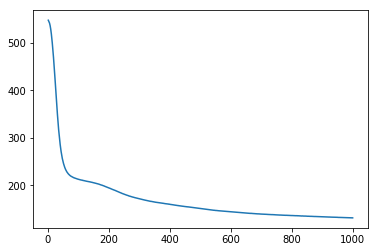

In [8]:
plt.plot(range(1, len(cost_log)+1), cost_log)
plt.show()

Original Images


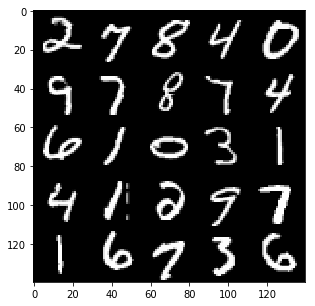

Reconstructed Images


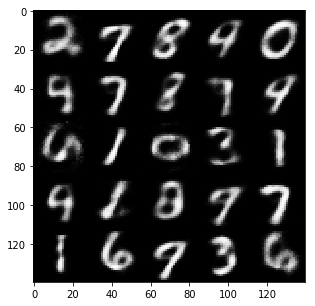

In [9]:
# Testing
# Encode and decode images from test set and visualize their reconstruction.
n = 5
canvas_orig = np.empty((28 * n, 28 * n))
canvas_recon = np.empty((28 * n, 28 * n))
for i in range(n):
    # MNIST test set
    batch_x, _ = mnist.test.next_batch(n)
    # Encode and decode the digit image
    g = edn.generate(batch_x)
    
    # Display original images
    for j in range(n):
        # Draw the generated digits
        canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = batch_x[j].reshape([28, 28])
    # Display reconstructed images
    for j in range(n):
        # Draw the generated digits
        canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

print("Original Images")     
plt.figure(figsize=(n, n))
plt.imshow(canvas_orig, origin="upper", cmap="gray")
plt.show()

print("Reconstructed Images")
plt.figure(figsize=(n, n))
plt.imshow(canvas_recon, origin="upper", cmap="gray")
plt.show()